In [1]:
# import sys and os to manipulate the path
import sys
import os

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the directory containing 'models' to the Python path
sys.path.append(os.path.join(os.getcwd(), '../'))

# import modules
from models.utils import plot_accuracy, fit_and_score, plot_confusion_matrix, build_pipeline, export_models
from models.utils import print_scores, cross_validated_metrics, plot_validated_metrics, fine_tune_model
from models.processors import DataProcessor, ModelInputs

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Read and process CSV file
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
processor = DataProcessor(df)
processor.process()
df = processor.df

In [3]:
# Create model inputs
inputs = ModelInputs(df)
inputs.process(test_size=.42)

In [4]:
# Instantiate models
models = {
    'Multinomial Logistic Regression': OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)),
    'Random Forest': RandomForestClassifier(random_state=42),
    'GBC': GradientBoostingClassifier(random_state=42)
}

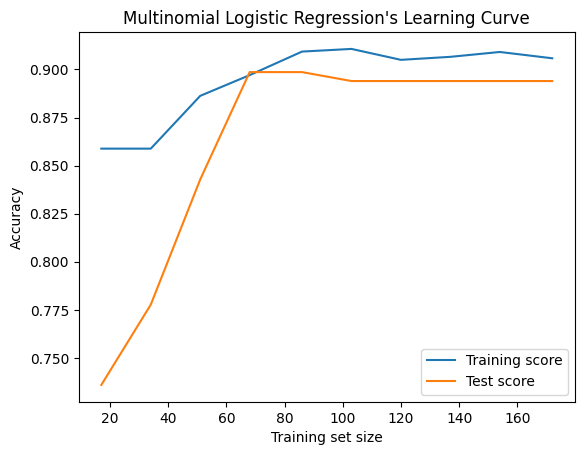

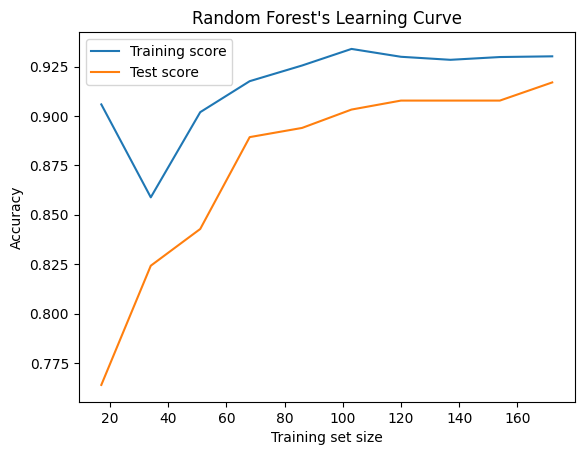

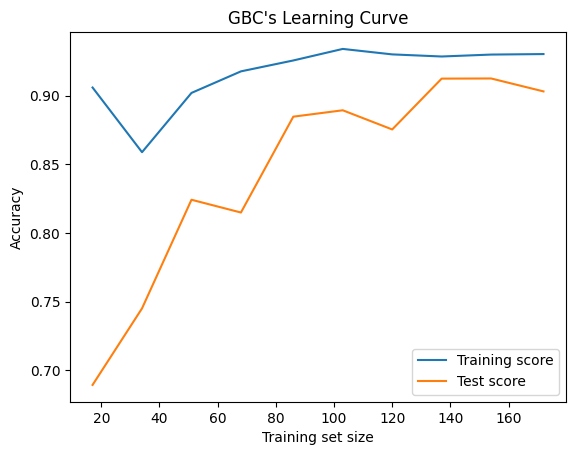

In [5]:
# Model training
scores = fit_and_score(models, inputs.X_train, inputs.X_test, inputs.y_train, inputs.y_test)

In [6]:
print_scores(scores)

Multinomial Logistic Regression Test:0.8924050632911392

Multinomial Logistic Regression Training:0.9027777777777778

Multinomial Logistic Regression Accuracy Score:0.8924050632911392

Multinomial Logistic Regression Learning Curve:None

Random Forest Test:0.8924050632911392

Random Forest Training:0.9305555555555556

Random Forest Accuracy Score:0.8924050632911392

Random Forest Learning Curve:None

GBC Test:0.8987341772151899

GBC Training:0.9305555555555556

GBC Accuracy Score:0.8987341772151899

GBC Learning Curve:None



Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits


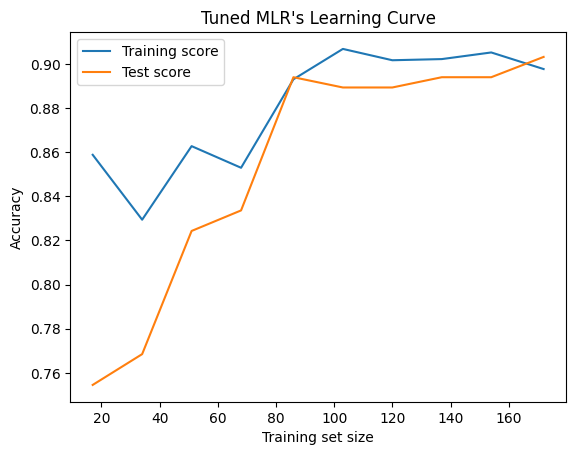

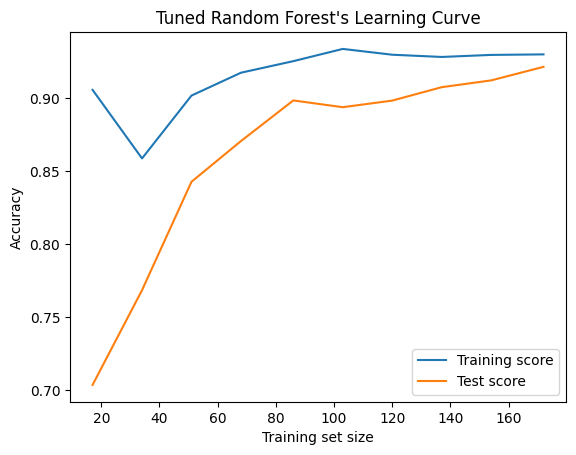

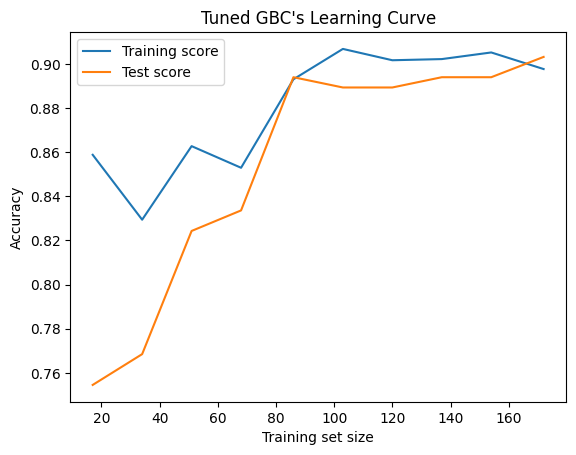

In [7]:
# Hyperparameter Tuning - Random Forest Classifier & GBC
random_forest_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

gbc_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__max_features': ['sqrt', 'log2']
}

mlr_param_grid = {
    'classifier__estimator__C': np.logspace(-4, 4, 30),
    'classifier__estimator__penalty': ['l2'],
    'classifier__estimator__solver': ['saga', 'lbfgs']
}

rf_pipeline = build_pipeline(RandomForestClassifier(random_state=42))
gbc_pipeline = build_pipeline(GradientBoostingClassifier(random_state=42))
mlr_pipeline = build_pipeline(OneVsRestClassifier(LogisticRegression(max_iter=10000, random_state=42)))

tuned_models = {
    'Tuned MLR': fine_tune_model(mlr_pipeline, mlr_param_grid, inputs.X_train, inputs.y_train),
    'Tuned Random Forest': fine_tune_model(rf_pipeline, random_forest_param_grid, inputs.X_train, inputs.y_train),
    'Tuned GBC': fine_tune_model(mlr_pipeline,mlr_param_grid, inputs.X_train, inputs.y_train)
}
inputs = ModelInputs(df)
inputs.process(test_size=0.42)
fine_tuned_scores = fit_and_score(tuned_models, inputs.X_train, inputs.X_test, inputs.y_train, inputs.y_test)

In [8]:
print_scores(fine_tuned_scores)

Tuned MLR Test:0.8924050632911392

Tuned MLR Training:0.8981481481481481

Tuned MLR Accuracy Score:0.8924050632911392

Tuned MLR Learning Curve:None

Tuned Random Forest Test:0.8987341772151899

Tuned Random Forest Training:0.9305555555555556

Tuned Random Forest Accuracy Score:0.8987341772151899

Tuned Random Forest Learning Curve:None

Tuned GBC Test:0.8924050632911392

Tuned GBC Training:0.8981481481481481

Tuned GBC Accuracy Score:0.8924050632911392

Tuned GBC Learning Curve:None



In [9]:
# Cross validated metrics
x = df.drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder']

mlr_cv_metrics = cross_validated_metrics(models['Multinomial Logistic Regression'], x, y)
gbc_cv_metrics = cross_validated_metrics(models['GBC'], x, y)
rf_cv_metrics = cross_validated_metrics(models['Random Forest'], x, y)

tuned_mlr_cv_metrics = cross_validated_metrics(tuned_models['Tuned MLR'], x, y)
tuned_gbc_cv_metrics = cross_validated_metrics(tuned_models['Tuned GBC'], x, y)
tuned_rf_cv_metrics = cross_validated_metrics(tuned_models['Tuned Random Forest'], x, y)


/Users/vinnie/Documents/NCIRL/third_semester/Final-project/sleep_disorders/API/SleepSenseAPI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vinnie/Documents/NCIRL/third_semester/Final-project/sleep_disorders/API/SleepSenseAPI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vinnie/Documents/NCIRL/third_semester/Final-project/sleep_disorders/API/SleepSenseAPI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-d

In [10]:
# Regular models CV Metrics
print(f"MLR:{mlr_cv_metrics}")
print(f"GBC: {gbc_cv_metrics}")
print(f"RF: {rf_cv_metrics}")

MLR:   accuracy  precision    recall        f1
0  0.855207   0.885774  0.855207  0.841712
GBC:    accuracy  precision    recall        f1
0  0.686126   0.784645  0.686126  0.647408
RF:    accuracy  precision    recall        f1
0  0.799568   0.841439  0.799568  0.777742


<Axes: title={'center': 'Cross validated metrics'}>

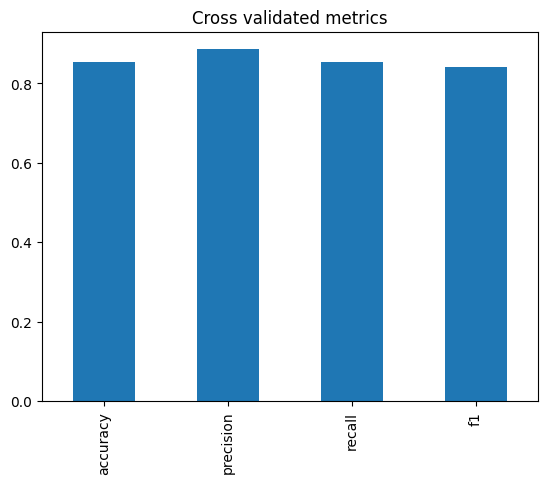

In [11]:
# Plot MLR Metrics
plot_validated_metrics(mlr_cv_metrics)

<Axes: title={'center': 'Cross validated metrics'}>

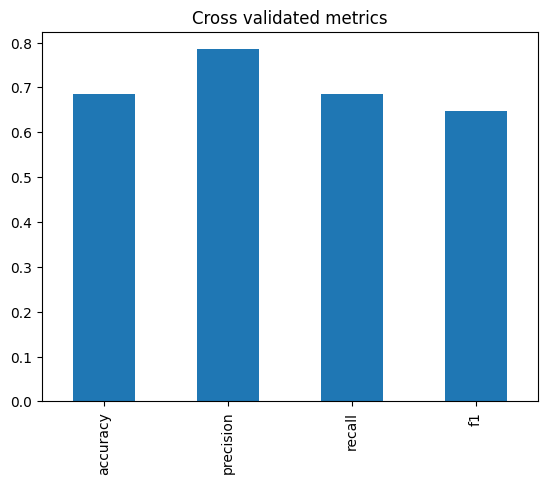

In [12]:
# Plot GBC Metrics
plot_validated_metrics(gbc_cv_metrics)

<Axes: title={'center': 'Cross validated metrics'}>

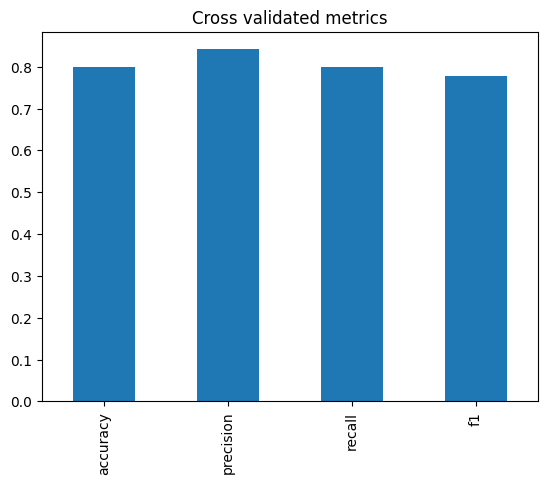

In [13]:
# Plot RF Metrics
plot_validated_metrics(rf_cv_metrics)

In [14]:
# Fine Tuned models CV Metrics
print(f"Tuned MLR:{tuned_mlr_cv_metrics}")
print(f"Tuned GBC: {tuned_gbc_cv_metrics}")
print(f"Tuned RF: {tuned_rf_cv_metrics}")

Tuned MLR:   accuracy  precision    recall        f1
0  0.860541    0.89098  0.860541  0.847797
Tuned GBC:    accuracy  precision    recall        f1
0  0.860541    0.89098  0.860541  0.847797
Tuned RF:    accuracy  precision    recall        f1
0  0.715784   0.805245  0.715784  0.680788


<Axes: title={'center': 'Cross validated metrics'}>

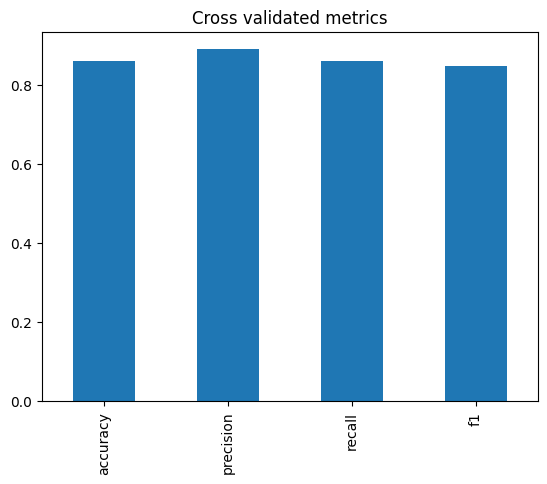

In [15]:
# Plot Tuned MLR Model
plot_validated_metrics(tuned_mlr_cv_metrics)

<Axes: title={'center': 'Cross validated metrics'}>

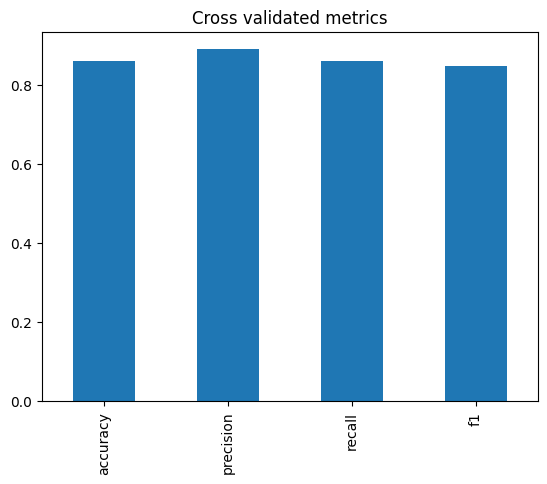

In [16]:
# Plot Tuned GBC Model
plot_validated_metrics(tuned_gbc_cv_metrics)

<Axes: title={'center': 'Cross validated metrics'}>

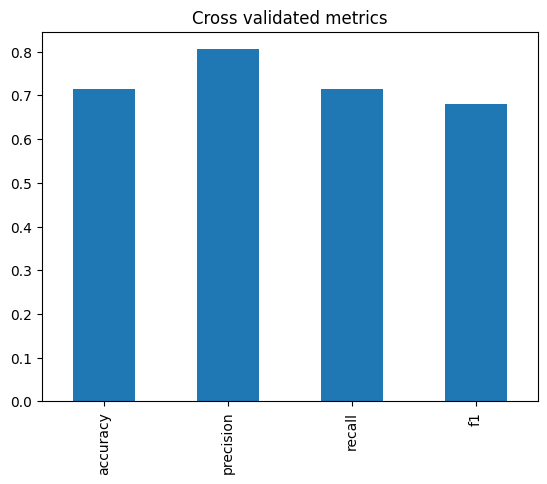

In [17]:
# Plot Tuned RF Model
plot_validated_metrics(tuned_rf_cv_metrics)

In [18]:
# Best Models
best_models = {'MLR': tuned_models['Tuned MLR'], 'GBC': tuned_models['Tuned GBC'], 'RF': models['Random Forest']}
export_models(best_models)

Model 'MLR' saved to '../models/predictors/MLR_model.pkl'
Model 'GBC' saved to '../models/predictors/GBC_model.pkl'
Model 'RF' saved to '../models/predictors/RF_model.pkl'
